In [75]:
import numpy as np
import pandas as pd
from pandas.api.types import is_object_dtype
from pandas.api.types import is_numeric_dtype
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
import warnings
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [76]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.options.display.float_format = '{:.2f}'.format
warnings.filterwarnings("ignore", category=FutureWarning)

In [77]:
train=pd.read_csv('/home/ivan_pronin/IT/kaggle/house-prices-advanced-regression-techniques/train.csv')
# train=pd.read_csv('C:/Users/julal/IT/kaggle/house-prices-advanced-regression-techniques/train.csv')
test=pd.read_csv('/home/ivan_pronin/IT/kaggle/house-prices-advanced-regression-techniques/test.csv')
# test=pd.read_csv('C:/Users/julal/IT/kaggle/house-prices-advanced-regression-techniques/test.csv')
data_description='/home/ivan_pronin/IT/kaggle/house-prices-advanced-regression-techniques/data_description.txt'
# data_description='C:/Users/julal/IT/kaggle/house-prices-advanced-regression-techniques/data_description.txt'

In [78]:
train=train.drop(columns=['Alley', 'PoolQC','Fence', 'MiscFeature','GarageArea', 'MSSubClass'])
test=test.drop(columns=['Alley', 'PoolQC','Fence', 'MiscFeature','GarageArea', 'MSSubClass'])

In [79]:
print(train.shape)
print(test.shape)

(1460, 75)
(1459, 74)


In [80]:
nonnumeric_features=[]
for col in train.columns:
    if is_object_dtype(train[col]):
        nonnumeric_features.append(col)

In [81]:
train[nonnumeric_features].describe()

,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition
count,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,588,1460,1460,1460,1423,1423,1422,1423,1422,1460,1460,1460,1459,1460,1460,770,1379,1379,1379,1379,1460,1460,1460
unique,5,2,4,4,2,5,3,25,9,8,5,8,6,8,15,16,3,4,5,6,4,4,4,6,6,6,5,2,5,4,7,5,6,3,5,5,3,9,6
top,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,TA,TA,PConc,TA,TA,No,Unf,Unf,GasA,Ex,Y,SBrkr,TA,Typ,Gd,Attchd,Unf,TA,TA,Y,WD,Normal
freq,1151,1454,925,1311,1459,1052,1382,225,1260,1445,1220,726,1141,1434,515,504,445,906,1282,647,649,1311,953,430,1256,1428,741,1365,1334,735,1360,380,870,605,1311,1326,1340,1267,1198


In [82]:
train.loc[:, ~train.columns.isin(nonnumeric_features)].describe()

,Id,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.00,1201.00,1460.00,1460.00,1460.00,1460.00,1460.00,1452.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1379.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00
mean,730.50,70.05,10516.83,6.10,5.58,1971.27,1984.87,103.69,443.64,46.55,567.24,1057.43,1162.63,346.99,5.84,1515.46,0.43,0.06,1.57,0.38,2.87,1.05,6.52,0.61,1978.51,1.77,94.24,46.66,21.95,3.41,15.06,2.76,43.49,6.32,2007.82,180921.20
std,421.61,24.28,9981.26,1.38,1.11,30.20,20.65,181.07,456.10,161.32,441.87,438.71,386.59,436.53,48.62,525.48,0.52,0.24,0.55,0.50,0.82,0.22,1.63,0.64,24.69,0.75,125.34,66.26,61.12,29.32,55.76,40.18,496.12,2.70,1.33,79442.50
min,1.00,21.00,1300.00,1.00,1.00,1872.00,1950.00,0.00,0.00,0.00,0.00,0.00,334.00,0.00,0.00,334.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00,0.00,1900.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,2006.00,34900.00
25%,365.75,59.00,7553.50,5.00,5.00,1954.00,1967.00,0.00,0.00,0.00,223.00,795.75,882.00,0.00,0.00,1129.50,0.00,0.00,1.00,0.00,2.00,1.00,5.00,0.00,1961.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,5.00,2007.00,129975.00
50%,730.50,69.00,9478.50,6.00,5.00,1973.00,1994.00,0.00,383.50,0.00,477.50,991.50,1087.00,0.00,0.00,1464.00,0.00,0.00,2.00,0.00,3.00,1.00,6.00,1.00,1980.00,2.00,0.00,25.00,0.00,0.00,0.00,0.00,0.00,6.00,2008.00,163000.00
75%,1095.25,80.00,11601.50,7.00,6.00,2000.00,2004.00,166.00,712.25,0.00,808.00,1298.25,1391.25,728.00,0.00,1776.75,1.00,0.00,2.00,1.00,3.00,1.00,7.00,1.00,2002.00,2.00,168.00,68.00,0.00,0.00,0.00,0.00,0.00,8.00,2009.00,214000.00
max,1460.00,313.00,215245.00,10.00,9.00,2010.00,2010.00,1600.00,5644.00,1474.00,2336.00,6110.00,4692.00,2065.00,572.00,5642.00,3.00,2.00,3.00,2.00,8.00,3.00,14.00,3.00,2010.00,4.00,857.00,547.00,552.00,508.00,480.00,738.00,15500.00,12.00,2010.00,755000.00


In [83]:
with open(data_description, 'r') as f:
    lines = f.readlines()
    for i, line in enumerate(lines):
#         if any(feature in line for feature in ['LotFrontage', 'MasVnrType', 'FireplaceQu']):
        if 'MSSubClass' in line:
            print(line)
            for j in range(i+1, min(i+10, len(lines))):
                print(lines[j])

MSSubClass: Identifies the type of dwelling involved in the sale.	



        20	1-STORY 1946 & NEWER ALL STYLES

        30	1-STORY 1945 & OLDER

        40	1-STORY W/FINISHED ATTIC ALL AGES

        45	1-1/2 STORY - UNFINISHED ALL AGES

        50	1-1/2 STORY FINISHED ALL AGES

        60	2-STORY 1946 & NEWER

        70	2-STORY 1945 & OLDER

        75	2-1/2 STORY ALL AGES



In [84]:
numeric_features=[]
for col in train.columns:
    if is_numeric_dtype(train[col]):
        numeric_features.append(col)
    else:
        pass
print(numeric_features)

['Id', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice']


In [85]:
zero_data_set_sum_train=train.isnull().sum()
zero_data_set_percentage_train=train.isnull().sum()/train.shape[0]*100
zero_data_set_train=pd.DataFrame({'sum':zero_data_set_sum_train, 'percentage': zero_data_set_percentage_train})
zero=zero_data_set_train.loc[zero_data_set_train['sum']>0]

In [86]:
zero

,sum,percentage
LotFrontage,259,17.74
MasVnrType,872,59.73
MasVnrArea,8,0.55
BsmtQual,37,2.53
BsmtCond,37,2.53
BsmtExposure,38,2.60
BsmtFinType1,37,2.53
BsmtFinType2,38,2.60
Electrical,1,0.07
FireplaceQu,690,47.26


In [87]:
train[nonnumeric_features]

,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition
0,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,NaN,Attchd,RFn,TA,TA,Y,WD,Normal
1,RL,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,Gable,CompShg,MetalSd,MetalSd,NaN,TA,TA,CBlock,Gd,TA,Gd,ALQ,Unf,GasA,Ex,Y,SBrkr,TA,Typ,TA,Attchd,RFn,TA,TA,Y,WD,Normal
2,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Mn,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,WD,Normal
3,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,Gable,CompShg,Wd Sdng,Wd Shng,NaN,TA,TA,BrkTil,TA,Gd,No,ALQ,Unf,GasA,Gd,Y,SBrkr,Gd,Typ,Gd,Detchd,Unf,TA,TA,Y,WD,Abnorml
4,RL,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Av,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,NaN,TA,TA,PConc,Gd,TA,No,Unf,Unf,GasA,Ex,Y,SBrkr,TA,Typ,TA,Attchd,RFn,TA,TA,Y,WD,Normal
1456,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,Gable,CompShg,Plywood,Plywood,Stone,TA,TA,CBlock,Gd,TA,No,ALQ,Rec,GasA,TA,Y,SBrkr,TA,Min1,TA,Attchd,Unf,TA,TA,Y,WD,Normal
1457,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,Gable,CompShg,CemntBd,CmentBd,NaN,Ex,Gd,Stone,TA,Gd,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,Gd,Attchd,RFn,TA,TA,Y,WD,Normal
1458,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,Hip,CompShg,MetalSd,MetalSd,NaN,TA,TA,CBlock,TA,TA,Mn,GLQ,Rec,GasA,Gd,Y,FuseA,Gd,Typ,NaN,Attchd,Unf,TA,TA,Y,WD,Normal


In [88]:
# def calc_weights(dist):
#   weights=0.25**dist+0.0000001
#   return weights

In [89]:
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.preprocessing import LabelEncoder

for col in zero.index:
    train2=train.copy()
    index_train=train2.loc[train2[col].isna()==False, col].index
    index_test=train2.loc[train2[col].isna()==True, col].index
    train2=train2.loc[:, ~train2.columns.isin(zero.index)]
    train2.drop(columns=['SalePrice'], inplace=True)
    y_train=train[col].loc[index_train]
    if col in nonnumeric_features:
        le_y = LabelEncoder()
        y_train=le_y.fit_transform(y_train)
    for feature in nonnumeric_features:
        if feature in train2.columns:
            le_x = LabelEncoder()
            train2[feature] = le_x.fit_transform(train2[feature])
    x_train=train2.loc[index_train]
    x_test=train2.loc[index_test]
    if x_train.shape[0]<6:
        neighbors=x_train.shape[0]
    else:
        neighbors=6
    if col in numeric_features:
        KNN_reg=KNeighborsRegressor(n_neighbors=neighbors, weights='distance')
        KNN_reg.fit(x_train,y_train)
        predictions=KNN_reg.predict(x_test)
        train.loc[index_test,col] = train.loc[index_test, col].fillna(predictions[0])
    else:
        KNN_clas=KNeighborsClassifier(n_neighbors=neighbors, weights='distance')
        KNN_clas.fit(x_train, y_train)
        predictions=KNN_clas.predict(x_test)
        predictions_transform = le_y.inverse_transform(predictions)
        train.loc[index_test, col] = train.loc[index_test, col].fillna(predictions_transform[0])

In [90]:
zero_data_set_sum_test=test.isnull().sum()
zero_data_set_percentage_test=test.isnull().sum()/test.shape[0]*100
zero_data_set_test=pd.DataFrame({'sum':zero_data_set_sum_test, 'percentage': zero_data_set_percentage_test})
zero2=zero_data_set_test.loc[zero_data_set_test['sum']>0]
zero2

,sum,percentage
MSZoning,4,0.27
LotFrontage,227,15.56
Utilities,2,0.14
Exterior1st,1,0.07
Exterior2nd,1,0.07
MasVnrType,894,61.27
MasVnrArea,15,1.03
BsmtQual,44,3.02
BsmtCond,45,3.08
BsmtExposure,44,3.02


In [91]:
for col in zero2.index:
    train2=test.copy()
    index_train=train2.loc[train2[col].isna()==False, col].index
    index_test=train2.loc[train2[col].isna()==True, col].index
    train2=train2.loc[:, ~train2.columns.isin(zero2.index)]
    y_train=test[col].loc[index_train]
    if col in nonnumeric_features:
        le_y = LabelEncoder()
        y_train=le_y.fit_transform(y_train)
    for feature in nonnumeric_features:
        if feature in train2.columns:
            le_x = LabelEncoder()
            train2[feature] = le_x.fit_transform(train2[feature])
    x_train=train2.loc[index_train]
    x_test=train2.loc[index_test]
    if x_train.shape[0]<6:
        neighbors=x_train.shape[0]
    else:
        neighbors=6
    if col in numeric_features:
        KNN_reg=KNeighborsRegressor(n_neighbors=neighbors, weights='distance')
        KNN_reg.fit(x_train,y_train)
        predictions=KNN_reg.predict(x_test)
        test.loc[index_test,col] = test.loc[index_test, col].fillna(predictions[0])
    else:
        KNN_clas=KNeighborsClassifier(n_neighbors=neighbors, weights='distance')
        KNN_clas.fit(x_train, y_train)
        predictions=KNN_clas.predict(x_test)
        predictions_transform = le_y.inverse_transform(predictions)
        test.loc[index_test, col] = test.loc[index_test, col].fillna(predictions_transform[0])

In [92]:
y2=train['SalePrice'].to_numpy().copy()
train2 = train.drop(columns=["SalePrice"]).copy()
test2 = test.copy()

In [93]:
train2.drop(columns=['Id'], inplace=True)
test2.drop(columns=['Id'], inplace=True)

In [94]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
for feature in nonnumeric_features:
        train2[feature] = le.fit_transform(train2[feature])
        test2[feature] = le.transform(test2[feature])

In [95]:
smoth_columns=[
               'LotArea',
               ]

In [96]:
for col in smoth_columns:
    q1 = np.percentile(train[col], 25)
    q3 = np.percentile(train[col], 75)
    iqr = q3 - q1
    lower_bound = q1 - 2 * iqr
    upper_bound = q3 + 2 * iqr
    train.loc[(train[col] > upper_bound) | (train[col] < lower_bound), col] = np.nan
    train[col].interpolate(method='polynomial', order=5, inplace=True)

In [97]:
for col in smoth_columns:
    q1 = np.percentile(test[col], 25)
    q3 = np.percentile(test[col], 75)
    iqr = q3 - q1
    lower_bound = q1 - 2 * iqr
    upper_bound = q3 + 2 * iqr
    test.loc[(test[col] > upper_bound) | (test[col] < lower_bound), col] = np.nan
    test[col].interpolate(method='polynomial', order=5, inplace=True)

In [98]:
train.loc[train['PoolArea']>0, 'PoolArea']=1
test.loc[test['PoolArea']>0, 'PoolArea']=1

In [99]:
test['BsmtFullBath']=test['BsmtFullBath'].astype(int)

In [100]:
train['allSF']=train['TotalBsmtSF']+train['1stFlrSF']+train['2ndFlrSF']
test['allSF']=test['TotalBsmtSF']+test['1stFlrSF']+test['2ndFlrSF']

In [101]:
numeric_features.append('allSF')
numeric_features.remove('TotalBsmtSF')

In [102]:
train2=train2.astype(float)
test2=test2.astype(float)

In [103]:
from sklearn.model_selection import train_test_split
x_train2, x_test2, y_train2, y_test2 = train_test_split(train2, y2, test_size=0.2, random_state=2)

In [104]:
x_train2.shape, y_train2.shape, x_test2.shape, y_test2.shape

((1168, 73), (1168,), (292, 73), (292,))

In [105]:
# clf = xgb.XGBClassifier(seed=42, subsample=0.9)
# cv_results = cross_val_score(clf,x_train , y_train,cv=kfold , scoring='accuracy')
# y_pred = cross_val_predict(clf,x_test,y_test,cv=10)
# proba = cross_val_predict(clf,x_test,y_test,cv=10, method='predict_proba')
# clf.fit(x_train , y_train , verbose=0, eval_set =[(x_test, y_test)])

In [106]:
from xgboost import XGBRegressor
XG=XGBRegressor(
    booster = 'gbtree',
    learning_rate = 0.01,
    colsample_bylevel = 0.5,
    colsample_bytree = 0.5,
    max_depth = 7,
    n_estimators = 1500,
    # eval_metric = 'rmse',
    # early_stopping_rounds = 50,
    tree_method = 'auto'
    )

XG.fit(train2, y2,
    #    eval_set = [(x_train2, y_train2), (x_test2, y_test2)], 
       verbose = 100)

XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=0.5, colsample_bynode=None, colsample_bytree=0.5,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, gpu_id=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [107]:
y_pred_xg_train=XG.predict(train2)
y_pred_xg_test=XG.predict(test2)


In [108]:
importances = XG.get_booster().get_score(importance_type='weight')
importances = sorted(importances.items(), key=lambda x: x[1], reverse=True)
importances

[('LotArea', 5691.0),
 ('LotFrontage', 4554.0),
 ('GrLivArea', 3520.0),
 ('BsmtUnfSF', 3463.0),
 ('TotalBsmtSF', 3420.0),
 ('YearBuilt', 3271.0),
 ('1stFlrSF', 3128.0),
 ('BsmtFinSF1', 3105.0),
 ('Neighborhood', 2906.0),
 ('YearRemodAdd', 2900.0),
 ('OverallCond', 2215.0),
 ('MasVnrArea', 2115.0),
 ('MoSold', 2103.0),
 ('OverallQual', 2099.0),
 ('GarageYrBlt', 2024.0),
 ('WoodDeckSF', 1964.0),
 ('2ndFlrSF', 1954.0),
 ('OpenPorchSF', 1940.0),
 ('Exterior1st', 1580.0),
 ('Condition1', 1253.0),
 ('TotRmsAbvGrd', 1242.0),
 ('Exterior2nd', 1183.0),
 ('MSZoning', 1172.0),
 ('YrSold', 1167.0),
 ('BsmtExposure', 1159.0),
 ('BsmtFinType1', 1148.0),
 ('HouseStyle', 1106.0),
 ('LotConfig', 1073.0),
 ('LotShape', 1065.0),
 ('SaleCondition', 871.0),
 ('BedroomAbvGr', 858.0),
 ('EnclosedPorch', 823.0),
 ('LandContour', 811.0),
 ('GarageCars', 797.0),
 ('BsmtFullBath', 749.0),
 ('Fireplaces', 745.0),
 ('BsmtFinSF2', 642.0),
 ('BsmtQual', 613.0),
 ('ScreenPorch', 609.0),
 ('FireplaceQu', 593.0),
 ('Ki

In [109]:
train['Y_pred']=y_pred_xg_train
test['Y_pred']=y_pred_xg_test

In [110]:
# numeric_features.append('Y_pred')

In [111]:
nonnumeric_features.extend([
                            'Id',
                            'BsmtFullBath',
                            ])

In [112]:
train[nonnumeric_features]=train[nonnumeric_features].astype('category')
test[nonnumeric_features]=test[nonnumeric_features].astype('category')

In [113]:
# data_list=['Neighborhood', 'BsmtQual', 'KitchenQual', 'FireplaceQu', 'ExterQual', 'GarageType', 'CentralAir', 'BsmtExposure']
# for col in data_list:
#     train[col]=train[col].astype(str)
# fig,ax=pl.subplots(1,8, figsize=(30,10))
# count=0
# for col in data_list:
#     ax[count].hist(train[col])
#     ax[count].set_xlabel(col)
#     count+=1
# plt.show()

array([[<Axes: title={'center': 'LotFrontage'}>,
        <Axes: title={'center': 'LotArea'}>,
        <Axes: title={'center': 'OverallQual'}>,
        <Axes: title={'center': 'OverallCond'}>,
        <Axes: title={'center': 'YearBuilt'}>,
        <Axes: title={'center': 'YearRemodAdd'}>],
       [<Axes: title={'center': 'MasVnrArea'}>,
        <Axes: title={'center': 'BsmtFinSF1'}>,
        <Axes: title={'center': 'BsmtFinSF2'}>,
        <Axes: title={'center': 'BsmtUnfSF'}>,
        <Axes: title={'center': 'TotalBsmtSF'}>,
        <Axes: title={'center': '1stFlrSF'}>],
       [<Axes: title={'center': '2ndFlrSF'}>,
        <Axes: title={'center': 'LowQualFinSF'}>,
        <Axes: title={'center': 'GrLivArea'}>,
        <Axes: title={'center': 'BsmtHalfBath'}>,
        <Axes: title={'center': 'FullBath'}>,
        <Axes: title={'center': 'HalfBath'}>],
       [<Axes: title={'center': 'BedroomAbvGr'}>,
        <Axes: title={'center': 'KitchenAbvGr'}>,
        <Axes: title={'center': 'TotR

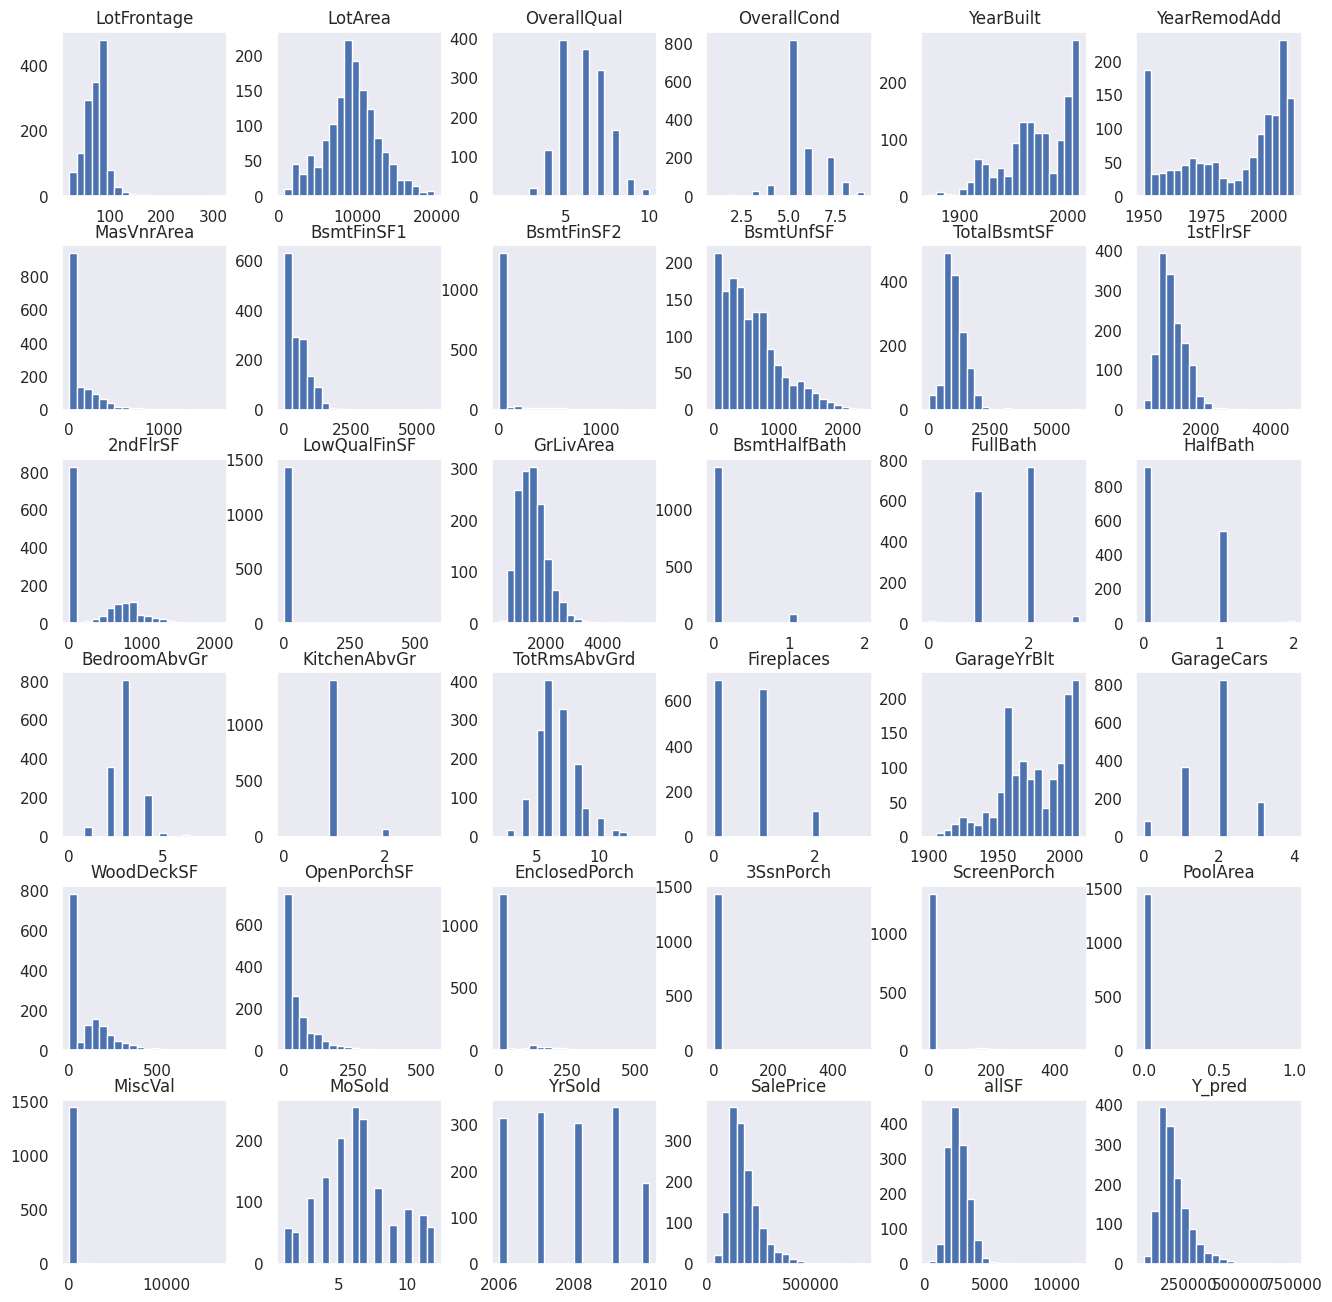

In [114]:
train.hist(figsize=(16,16), bins=20, grid=False)

In [115]:
train[numeric_features].columns

Index(['Id', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
       'GarageCars', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice',
       'allSF'],
      dtype='object')

In [116]:
# for col in numeric_features:
#     print(train[col].value_counts())

In [117]:
train[numeric_features].columns

Index(['Id', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
       'GarageCars', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice',
       'allSF'],
      dtype='object')

In [118]:
with open(data_description, 'r') as f:
    lines = f.readlines()
    for i, line in enumerate(lines):
#         if any(feature in line for feature in ['LotFrontage', 'MasVnrType', 'FireplaceQu']):
        if 'YearBuilt' in line:
            print(line)
            for j in range(i+1, min(i+10, len(lines))):
                print(lines[j])

YearBuilt: Original construction date



YearRemodAdd: Remodel date (same as construction date if no remodeling or additions)



RoofStyle: Type of roof



       Flat	Flat

       Gable	Gable

       Gambrel	Gabrel (Barn)

       Hip	Hip



In [119]:
train[nonnumeric_features]

,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition,Id,BsmtFullBath
0,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,WD,Normal,1,1
1,RL,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,Gable,CompShg,MetalSd,MetalSd,BrkFace,TA,TA,CBlock,Gd,TA,Gd,ALQ,Unf,GasA,Ex,Y,SBrkr,TA,Typ,TA,Attchd,RFn,TA,TA,Y,WD,Normal,2,0
2,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Mn,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,WD,Normal,3,1
3,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,Gable,CompShg,Wd Sdng,Wd Shng,BrkFace,TA,TA,BrkTil,TA,Gd,No,ALQ,Unf,GasA,Gd,Y,SBrkr,Gd,Typ,Gd,Detchd,Unf,TA,TA,Y,WD,Abnorml,4,1
4,RL,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Av,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,WD,Normal,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,TA,TA,PConc,Gd,TA,No,Unf,Unf,GasA,Ex,Y,SBrkr,TA,Typ,TA,Attchd,RFn,TA,TA,Y,WD,Normal,1456,0
1456,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,Gable,CompShg,Plywood,Plywood,Stone,TA,TA,CBlock,Gd,TA,No,ALQ,Rec,GasA,TA,Y,SBrkr,TA,Min1,TA,Attchd,Unf,TA,TA,Y,WD,Normal,1457,1
1457,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,Gable,CompShg,CemntBd,CmentBd,BrkFace,Ex,Gd,Stone,TA,Gd,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,Gd,Attchd,RFn,TA,TA,Y,WD,Normal,1458,0
1458,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,Hip,CompShg,MetalSd,MetalSd,BrkFace,TA,TA,CBlock,TA,TA,Mn,GLQ,Rec,GasA,Gd,Y,FuseA,Gd,Typ,TA,Attchd,Unf,TA,TA,Y,WD,Normal,1459,1


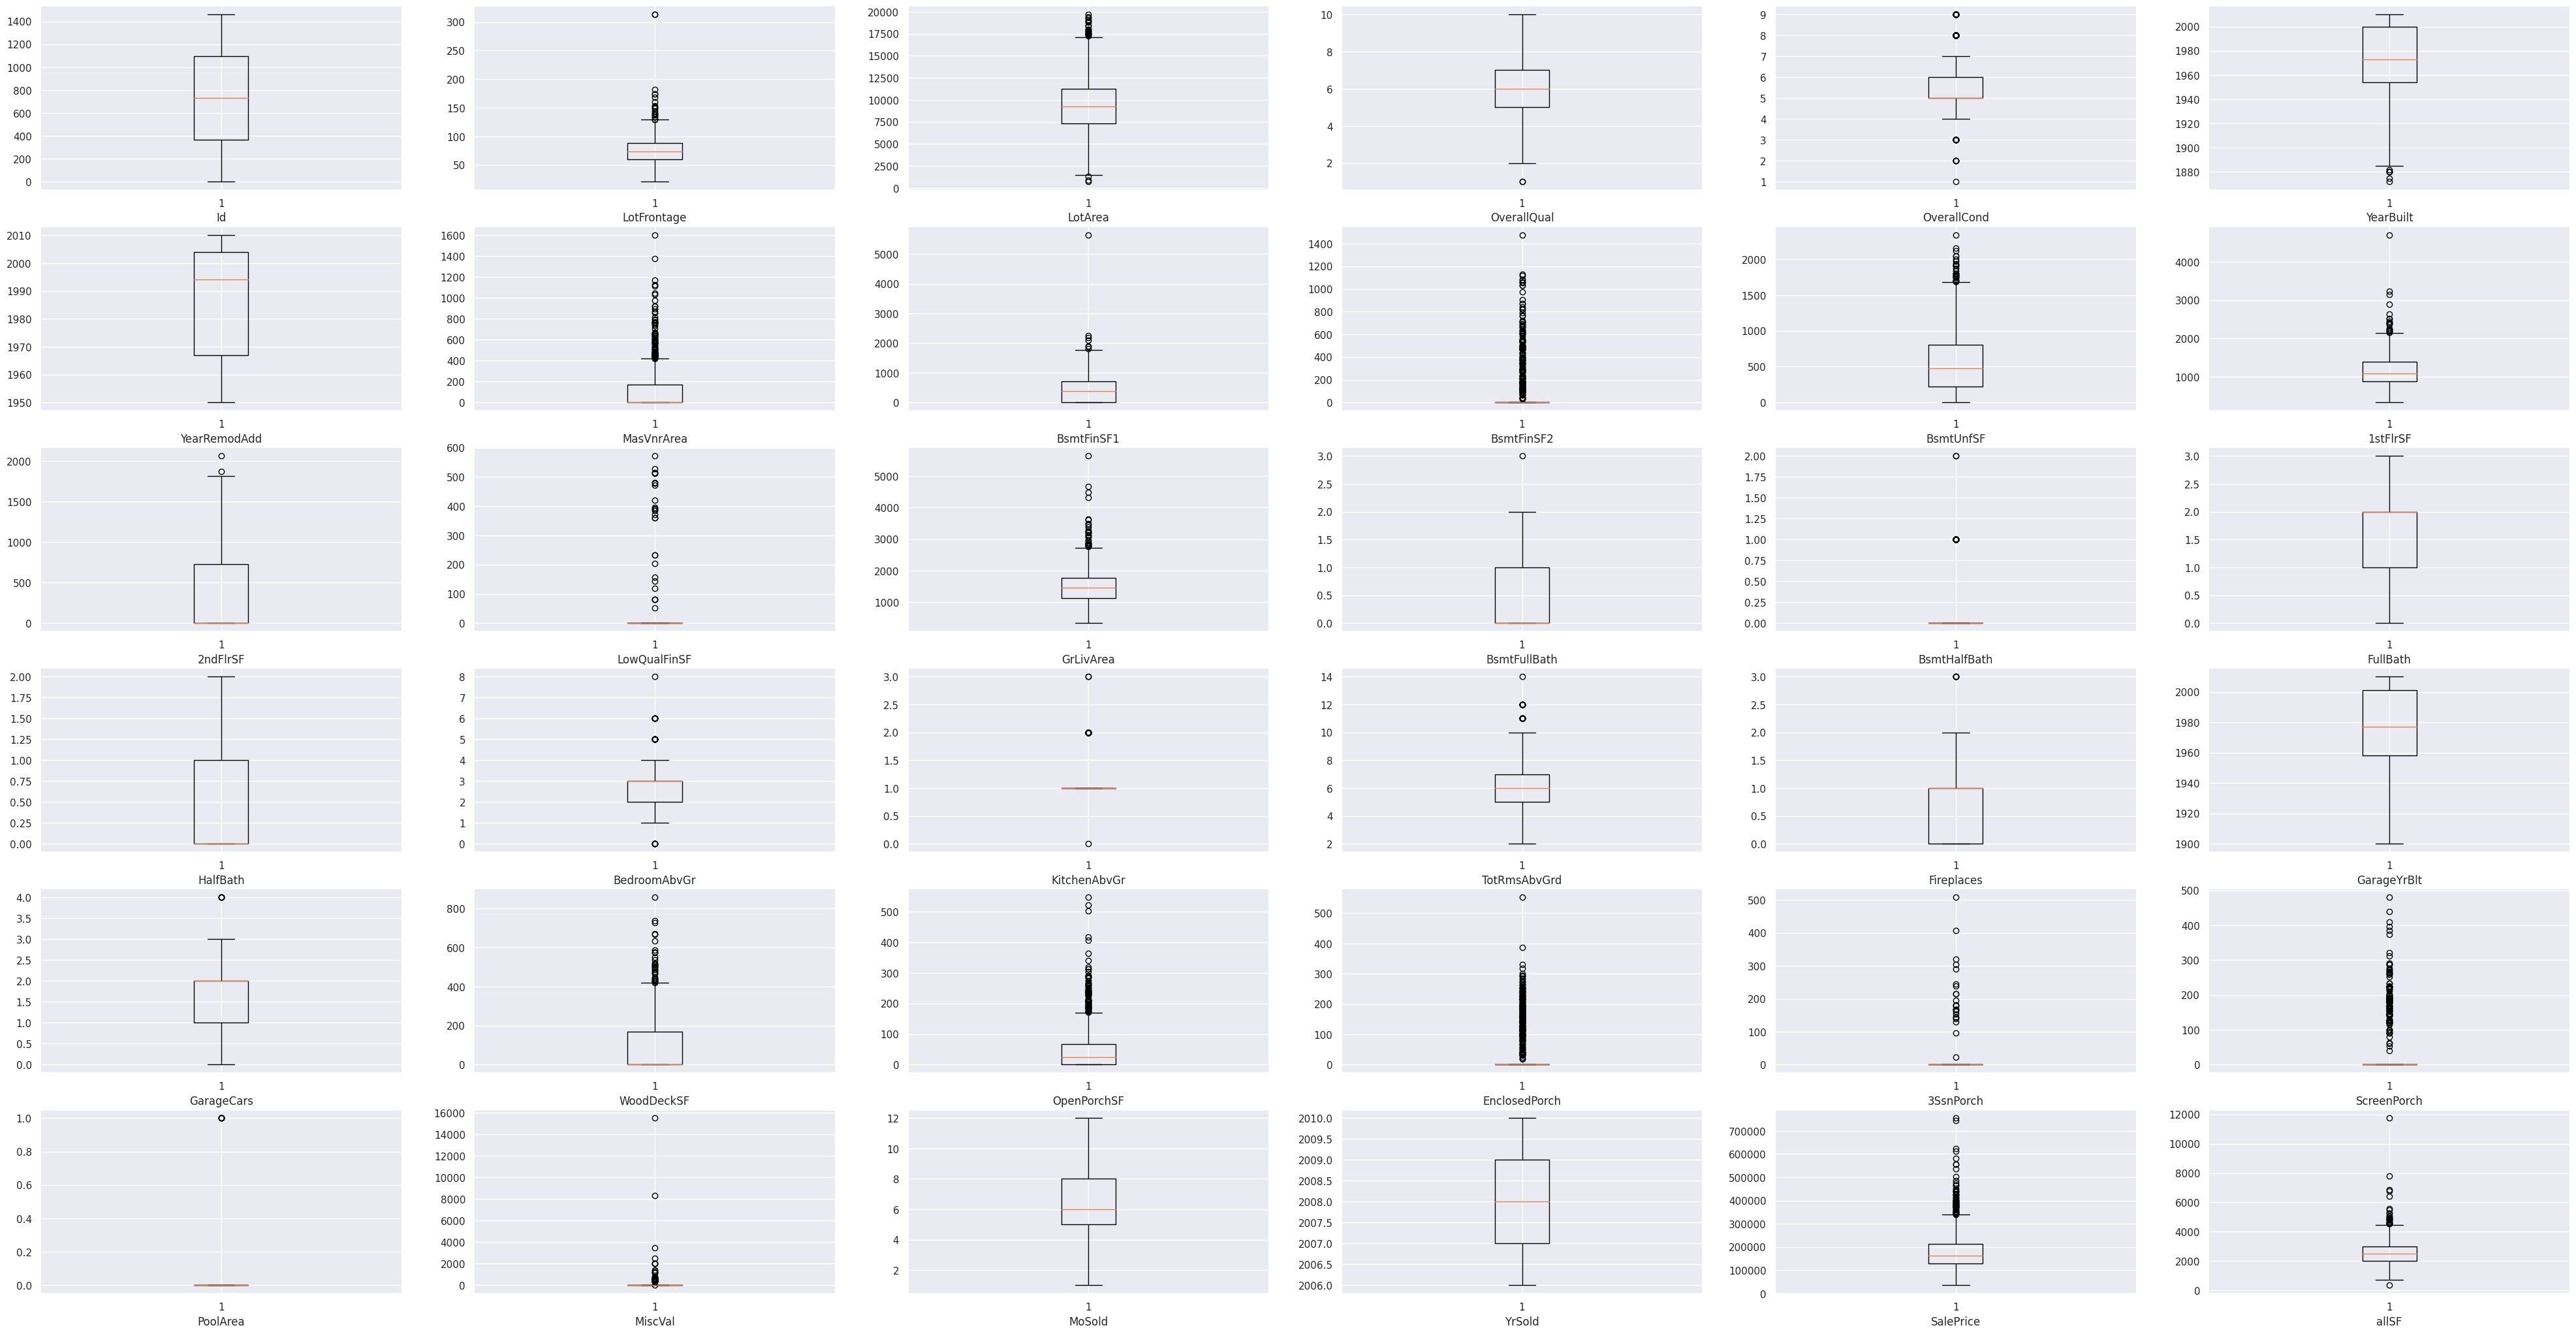

In [120]:
gs = gridspec.GridSpec(7, 6)
plt.figure(figsize=(50,30))

column=0
for i in range(7):
    column_curr=column
    for z in range(6):
        if column_curr <len(numeric_features):
            ax = plt.subplot(gs[i, z])
            ax.boxplot(train[train[numeric_features].columns[column_curr]])
            ax.set_xlabel(train[numeric_features].columns[column_curr])
            column_curr+=1
            column=column_curr
column+=7

plt.show()

In [121]:
train[numeric_features].columns

Index(['Id', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
       'GarageCars', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice',
       'allSF'],
      dtype='object')

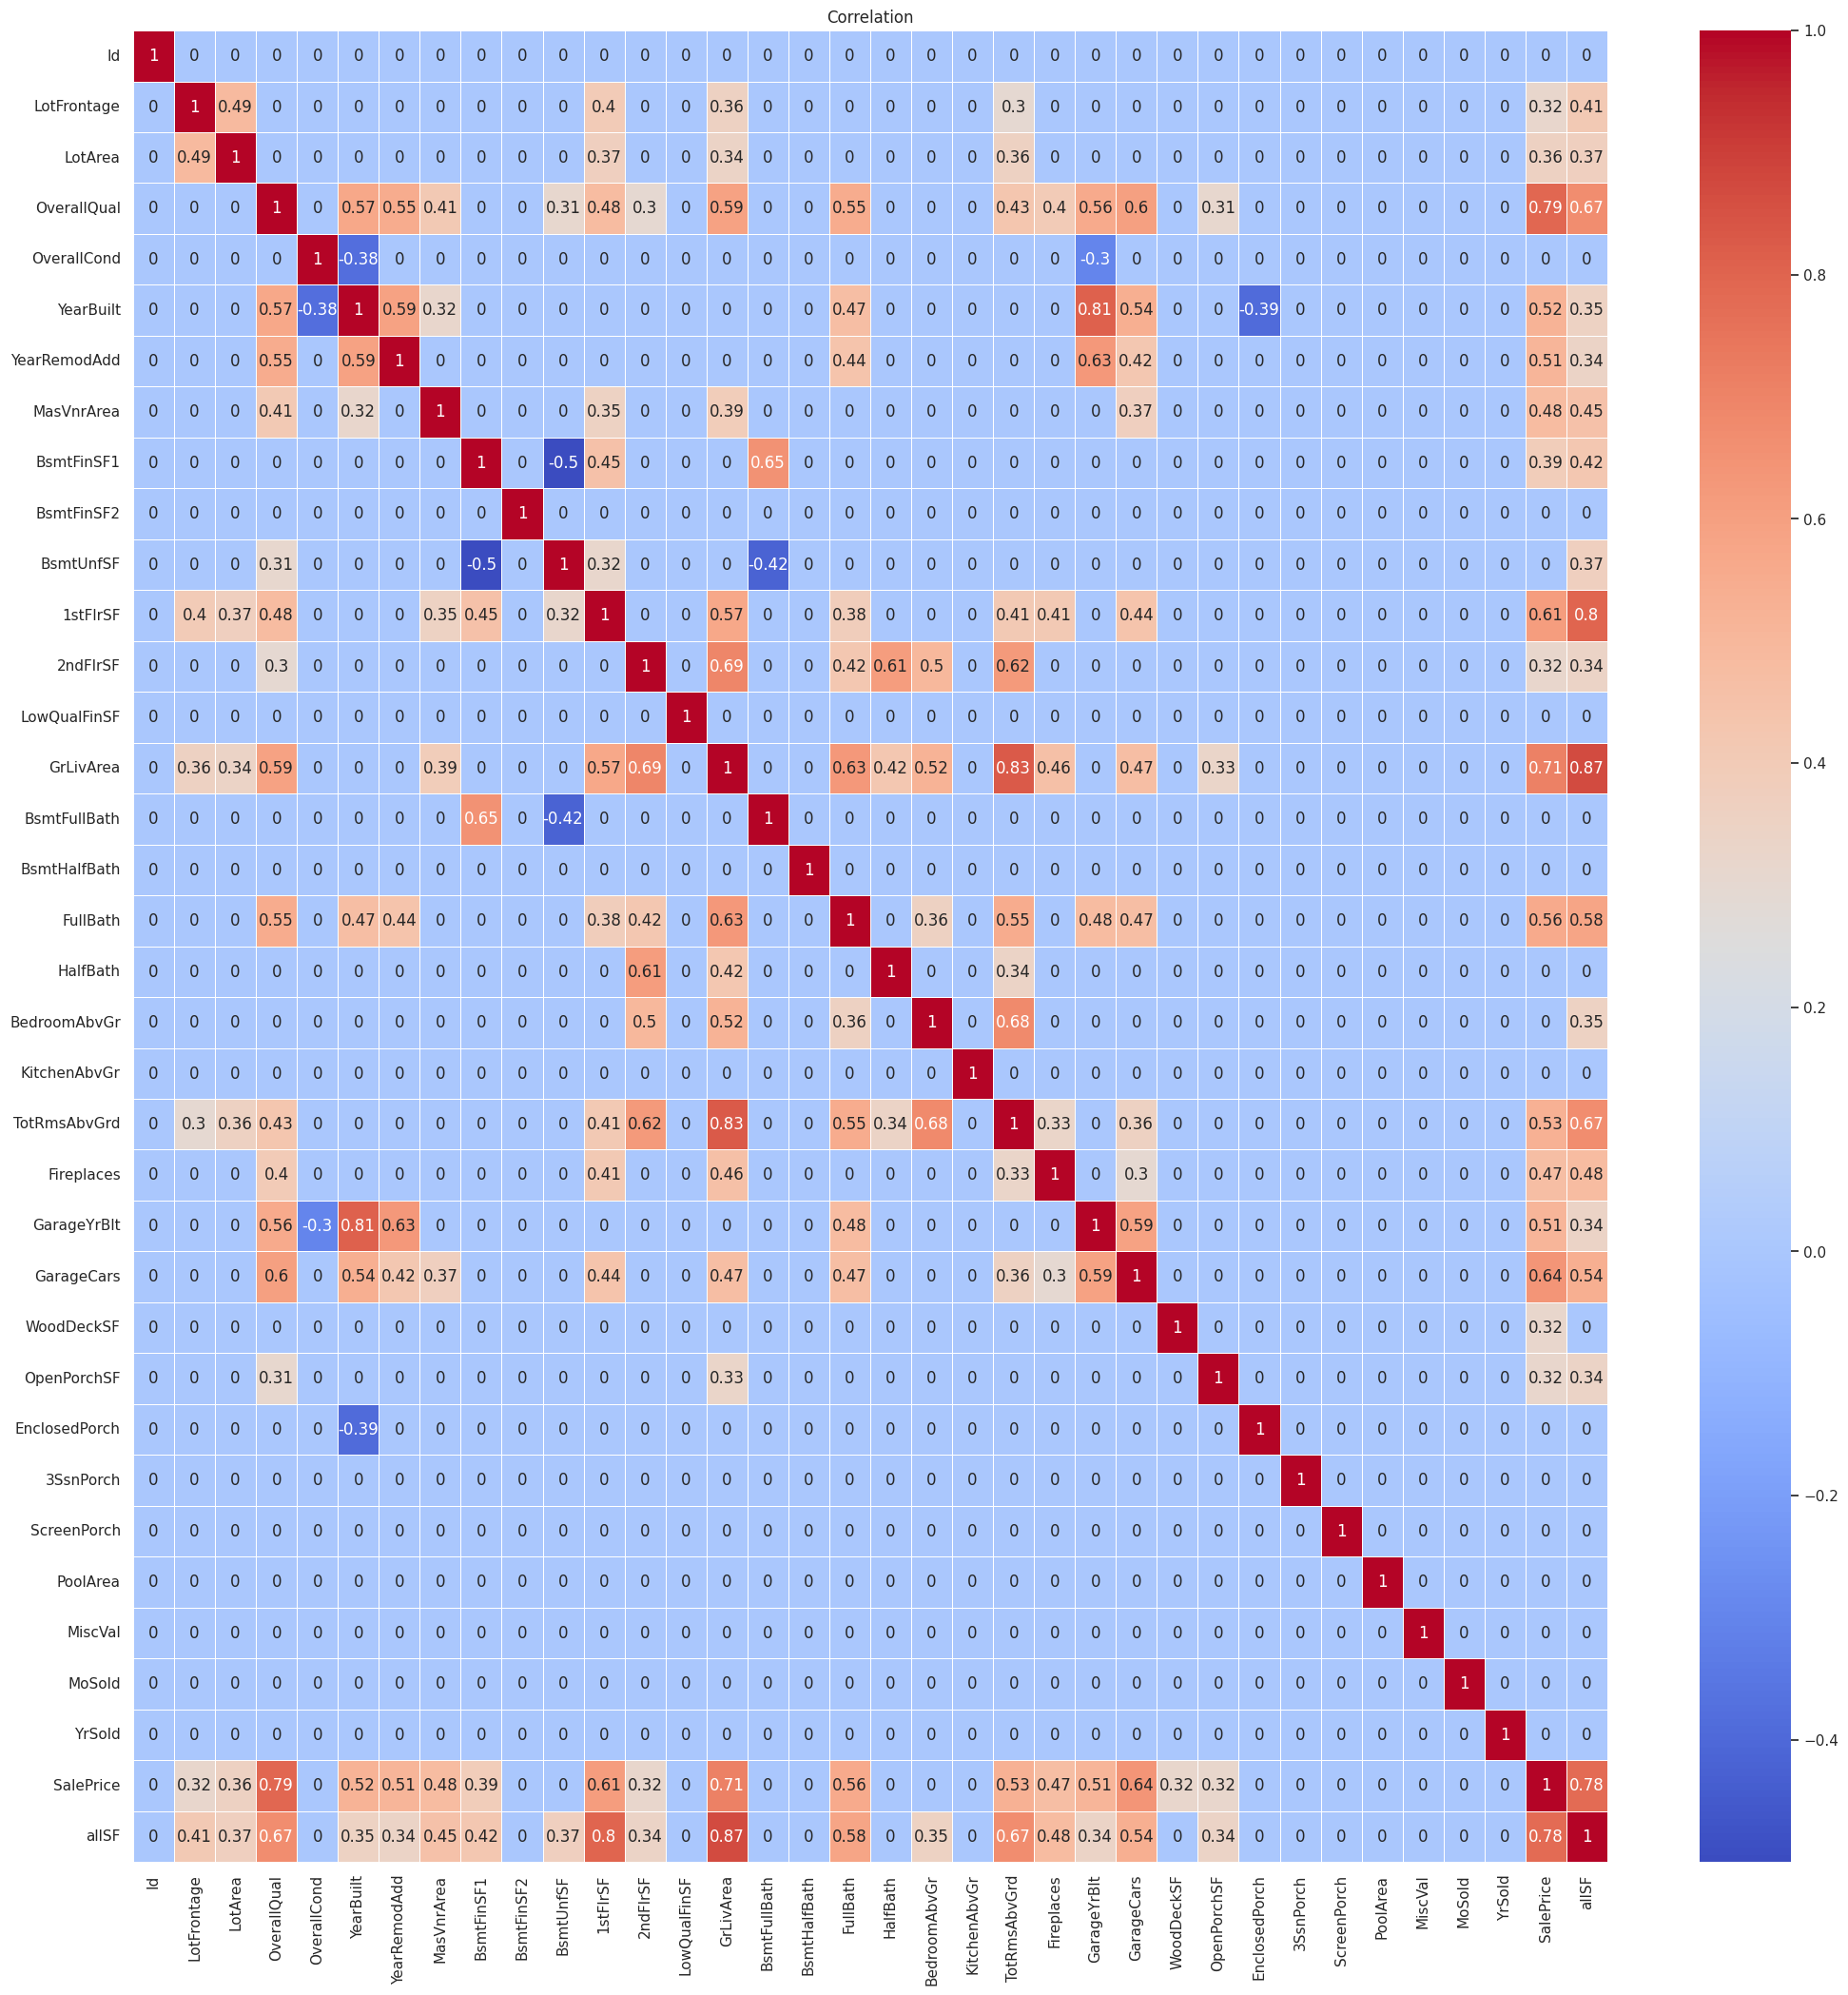

In [122]:
plt.figure(figsize=(25,25))

sns.set(font_scale=1)

corr_matrix=train[numeric_features].corr()
corr_matrix=np.round(corr_matrix,2)
corr_matrix[np.abs(corr_matrix)<0.3]=0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation')
plt.show()

In [123]:
y=train['SalePrice'].to_numpy()
train.drop(columns=['SalePrice'], inplace=True)

In [124]:
numeric_features.remove('SalePrice')

In [125]:
for col in numeric_features:
    train[col]=train[col].astype(str)
    test[col]=test[col].astype(str)

In [126]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(train, y, test_size=0.2, random_state=2)

In [127]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((1168, 76), (1168,), (292, 76), (292,))

In [134]:
import catboost as cb
train_dataset = cb.Pool(train,y,
                        cat_features=nonnumeric_features
)                                                     
# test_dataset = cb.Pool(x_test,y_test,          
#                        cat_features=nonnumeric_features)

In [135]:
CAT=cb.CatBoostRegressor(metric_period=100,
                        #  eval_metric='RMSE',
                         task_type='CPU',
                         iterations=3200, 
                         learning_rate=0.01,
                        #  early_stopping_rounds = 50,
                         depth=7,
                         
                         
                        )
history=CAT.fit(train_dataset,
        # eval_set=test_dataset
)

0:	learn: 78823.3256278	total: 12.9ms	remaining: 41.2s
100:	learn: 39599.1420640	total: 2.94s	remaining: 1m 30s
200:	learn: 21951.8800509	total: 5.74s	remaining: 1m 25s
300:	learn: 13878.8309764	total: 8.56s	remaining: 1m 22s
400:	learn: 10254.3271018	total: 11.6s	remaining: 1m 20s
500:	learn: 8452.8490743	total: 14.6s	remaining: 1m 18s
600:	learn: 7326.8833839	total: 17.6s	remaining: 1m 16s
700:	learn: 6560.6880800	total: 20.5s	remaining: 1m 13s
800:	learn: 5950.7738134	total: 23.6s	remaining: 1m 10s
900:	learn: 5442.5582174	total: 26.6s	remaining: 1m 7s
1000:	learn: 5057.0751934	total: 29.8s	remaining: 1m 5s
1100:	learn: 4734.9840448	total: 33s	remaining: 1m 2s
1200:	learn: 4483.3561916	total: 36.1s	remaining: 1m
1300:	learn: 4271.6136129	total: 39.2s	remaining: 57.3s
1400:	learn: 4089.6101817	total: 42.4s	remaining: 54.4s
1500:	learn: 3928.5781680	total: 45.6s	remaining: 51.6s
1600:	learn: 3782.1051432	total: 48.7s	remaining: 48.7s
1700:	learn: 3661.8295872	total: 52s	remaining: 45.

In [136]:
feature_importance = CAT.get_feature_importance(train_dataset)
feature_names = train.columns

feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
feature_importance_df.sort_values(by='Importance', ascending=False, inplace=True)

feature_importance_df

,Feature,Importance
75,Y_pred,81.29
74,allSF,2.90
10,Neighborhood,1.42
58,GarageFinish,1.25
28,BsmtQual,1.23
51,KitchenQual,1.22
25,ExterQual,0.77
36,TotalBsmtSF,0.77
15,OverallQual,0.74
56,GarageType,0.71


In [137]:
y_pred_cat_train=CAT.predict(train)
y_pred_cat_test=CAT.predict(test)

In [58]:
train3=train2.copy()
test3=test2.copy()
y3=y2.copy()

In [59]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler2 = StandardScaler()
scaler3 = StandardScaler()
# scaler = MinMaxScaler()

train3= scaler.fit_transform(train3).astype(float)
test3 = scaler2.fit_transform(test3).astype(float)
y3 = scaler3.fit_transform(y3.reshape(-1, 1))

In [60]:
from sklearn.model_selection import train_test_split
x_train2, x_test2, y_train2, y_test2 = train_test_split(train3, y3, test_size=0.2, random_state=2)

In [61]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping

MLP = Sequential([
        Dense(10, input_shape=(train3.shape[1],)),
        Dense(1)
    ])

# MLP.summary()

MLP.compile(optimizer='adam', loss='mse')

2023-10-17 17:50:02.402920: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 17:50:02.915148: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-10-17 17:50:03.388243: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-17 17:50:03.408315: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-17 17:50:03.408372: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_exec

In [62]:
# early_stopping = EarlyStopping(monitor='loss', patience=50)
history=MLP.fit(train3,y3, 
                epochs=100, 
                # validation_data=(x_test2, y_test2), 
                # callbacks=[early_stopping],
                verbose=False
                )

2023-10-17 17:50:04.986213: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-10-17 17:50:04.989467: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f3b0c026a10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-17 17:50:04.989491: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4070, Compute Capability 8.9
2023-10-17 17:50:04.992988: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-17 17:50:05.087707: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-10-17 17:50:05.157985: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the p

In [63]:
y_pred_mlp_train=MLP.predict(train3)
y_pred_mlp_test=MLP.predict(test3)

46/46 [==============================] - 0s 1ms/step


In [64]:
y_pred_mlp_train_transform=np.squeeze(scaler3.inverse_transform(y_pred_mlp_train.reshape(-1, 1)))
y_pred_mlp_test_transform=np.squeeze(scaler3.inverse_transform(y_pred_mlp_test.reshape(-1, 1)))
# y_test_after=scaler3.inverse_transform(y_test2.reshape(-1, 1))

In [65]:
# from sklearn.metrics import mean_squared_error
# mse_test_mlp=mean_squared_error(y_test2, y_pred_mlp_test)
# mse_train_mlp=history.history["loss"][-1]
# quantity_of_epochs = history.epoch[-1] + 1

# print(f'MSE on test is {mse_test_mlp:.05f}')
# print(f'MSE on train is {mse_train_mlp:.05f}')
# print(f'The best result stopped on {quantity_of_epochs}')
# print(f'MSE on test_data is more/less train_data by {(mse_test_mlp/mse_train_mlp-1):.03f}')

In [66]:
# print(f'rmse after first launch of MLP is {np.sqrt(np.sum((np.squeeze(y_test_after)-np.squeeze(y_pred_mlp_test_transform))**2)/len(y_pred_mlp_test_transform))}')

In [67]:
# print(f'rmse before MLP cycle is {np.sqrt(np.sum((np.squeeze(y_test_after)-np.squeeze(y_pred_mlp_test_transform))**2)/len(y_pred_mlp_test_transform))}')
# result_train = np.hstack((x_train2, y_pred_mlp_train))
# result_test = np.hstack((x_test2, y_pred_mlp_test))
# x_train2 = result_train
# x_test2 = result_test

# n=5
# for i in range(1, n+1):
#     if i<=4:
#         MLP = Sequential([
#             Dense(i*2, input_shape=(x_train2.shape[1],)),
#             Dropout(0.5),
#             Dense(1)
#         ])
#         MLP.compile(optimizer='sgd', loss='mse')
#     else:
#         MLP = Sequential([
#             Dense(i, input_shape=(x_train2.shape[1],)),
#             Dense(1)
#         ])
#         MLP.compile(optimizer='adam', loss='mse')
#     early_stopping = EarlyStopping(monitor='loss', patience=50)
#     history = MLP.fit(x_train2, y_train2,
#                       epochs=1000,
#                       validation_data=(x_test2, y_test2),
#                       callbacks=[early_stopping],
#                       verbose=False
#                       )
#     y_pred_mlp_train = MLP.predict(x_train2)
#     y_pred_mlp_test = MLP.predict(x_test2)
#     quantity_of_epochs = history.epoch[-1] + 1
#     mse_test_mlp=mean_squared_error(y_test2, y_pred_mlp_test)
#     mse_train_mlp=history.history["loss"][-1]
#     print(f'The best result stopped on {quantity_of_epochs}')
#     print(f'MSE on last test is {mse_test_mlp:.05f}')
#     print(f'MSE on last train is {mse_train_mlp:.05f}')
#     print(f'MSE on last test_data is more/less last train_data by {(mse_test_mlp/mse_train_mlp-1):.03f}')
#     y_pred_test3 = scaler3.inverse_transform(y_pred_mlp_test.reshape(-1, 1))
#     print(f'rmse after {i} MLP cycle is {np.sqrt(np.sum((np.squeeze(y_test_after)-np.squeeze(y_pred_test3))**2)/len(y_pred_test3))}')
#     result_train = np.hstack((x_train2, y_pred_mlp_train))
#     result_test = np.hstack((x_test2, y_pred_mlp_test))
#     x_train2 = result_train
#     x_test2 = result_test
#     i+=1

In [68]:
# y_pred_ml_train=CAT.predict(train)
# y_pred_ml_test=CAT.predict(test)

In [69]:
# gs = gridspec.GridSpec(7, 6)
# plt.figure(figsize=(50,30))

# column=0
# for i in range(7):
#     column_curr=column
#     for z in range(6):
#         if column_curr <len(nonnumeric_features):
#             ax = plt.subplot(gs[i, z])
#             sns.violinplot(data=train[nonnumeric_features], x=train[nonnumeric_features].columns[column_curr], y=y2)
#             ax.set_xlabel(train[nonnumeric_features].columns[column_curr])
#             column_curr+=1
#             column=column_curr
# column+=7

# plt.show()

In [70]:
# gs = gridspec.GridSpec(7, 6)
# plt.figure(figsize=(50,30))

# column=0
# for i in range(7):
#     column_curr=column
#     for z in range(6):
#         if column_curr <len(numeric_features):
#             ax = plt.subplot(gs[i, z])
#             sns.violinplot(data=train2[numeric_features], x=train2[numeric_features].columns[column_curr], y=y2)
#             ax.set_xlabel(train2[numeric_features].columns[column_curr])
#             column_curr+=1
#             column=column_curr
# column+=7

# plt.show()

In [59]:
new_train = pd.DataFrame({'XG_prediction': y_pred_xg_train, 'CAT_prediction': y_pred_cat_train,
                        #    'MLP_prediction': y_pred_mlp_train_transform
                           })
new_test = pd.DataFrame({'XG_prediction': y_pred_xg_test, 'CAT_prediction': y_pred_cat_test, 
                        #  'MLP_prediction': y_pred_mlp_test_transform
                         })
new_y=y.copy()

In [60]:
new_train

,XG_prediction,CAT_prediction
0,205242.27,204795.73
1,180099.75,181005.82
2,216957.66,211983.94
3,141765.38,163080.08
4,259251.64,272984.70
...,...,...
1455,174337.59,174794.54
1456,208213.91,210149.34
1457,266753.25,266702.80
1458,141340.81,140214.25


In [61]:
new_train.shape, new_test.shape, new_y.shape

((1460, 2), (1459, 2), (1460,))

In [87]:
from sklearn.model_selection import train_test_split
x_train3, x_test3, y_train3, y_test3 = train_test_split(new_train, new_y, test_size=0.2, random_state=2)

In [139]:
from lightgbm import LGBMRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression


estimators = [('xgboost', XG), ('catboost', CAT)]

# final_estimator = LinearRegression()
final_estimator = LGBMRegressor(n_estimators=100,
                                max_depth=7,
                                learning_rate=0.2)

stacking_clf = StackingRegressor(
    estimators=estimators, final_estimator=final_estimator)

stacking_clf.fit(new_train, new_y,
                 )

0:	learn: 78722.1691066	total: 1.51ms	remaining: 4.83s
100:	learn: 34331.2382190	total: 66.8ms	remaining: 2.05s
200:	learn: 17090.3896043	total: 136ms	remaining: 2.02s
300:	learn: 10613.0309362	total: 210ms	remaining: 2.02s
400:	learn: 8368.7985368	total: 283ms	remaining: 1.97s
500:	learn: 7557.1220845	total: 349ms	remaining: 1.88s
600:	learn: 7137.7990720	total: 415ms	remaining: 1.8s
700:	learn: 6842.6354132	total: 485ms	remaining: 1.73s
800:	learn: 6614.3661285	total: 552ms	remaining: 1.65s
900:	learn: 6430.0101696	total: 618ms	remaining: 1.57s
1000:	learn: 6282.6937612	total: 690ms	remaining: 1.51s
1100:	learn: 6160.0740535	total: 771ms	remaining: 1.47s
1200:	learn: 6050.7698431	total: 840ms	remaining: 1.4s
1300:	learn: 5952.1561630	total: 909ms	remaining: 1.33s
1400:	learn: 5862.6119870	total: 974ms	remaining: 1.25s
1500:	learn: 5788.5008455	total: 1.04s	remaining: 1.18s
1600:	learn: 5723.4500008	total: 1.11s	remaining: 1.11s
1700:	learn: 5663.0248891	total: 1.18s	remaining: 1.04s


StackingRegressor(estimators=[('xgboost',
                               XGBRegressor(base_score=None, booster='gbtree',
                                            callbacks=None,
                                            colsample_bylevel=0.5,
                                            colsample_bynode=None,
                                            colsample_bytree=0.5,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            gpu_id=None, grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learn...
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=1500, n_jobs=None,
                                            num_parallel_tree=None,
                                            predictor=None, random_state=None, ...)),
                              ('catboost',
                               <catboost.core.CatBoostRegressor object at 0x7ffad871d350>)],
                  final_estimator=LGBMRegressor(learning_rate=0.2, max_depth=7))

In [145]:
predictions=stacking_clf.predict(new_test)
predictions

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


array([127320.81744216, 156439.19231252, 180355.31013955, ...,
       162587.42511251, 123318.30793476, 230978.08978163])

In [141]:
# from sklearn.metrics import mean_squared_error

# rmse=np.sqrt(mean_squared_error(y_test3, predictions))
# print(rmse)

In [142]:
# predictions=CAT_final.predict(new_test)
# predictions

In [143]:
# predictions=XG.predict(new_test)
# predictions

In [144]:
output = pd.DataFrame({'Id': test.Id, 'SalePrice': predictions})
output.to_csv('my_answer17.csv', index=False)